<a href="https://colab.research.google.com/github/Rosscros/NN-MISIS/blob/main/%D0%9D%D0%A3%D0%BB%D0%B0%D0%B11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import numpy as np
import _pickle as cPickle
import gzip
import os
from sklearn.utils import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

Task 1. Fill one_hot_encoded, check_accuracy and softmax functions

In [29]:
# Функция для выполнения one-hot кодирования меток
def one_hot_encoded(y, num_class):
    # Создание нулевой матрицы для хранения one-hot представления
    one_hot = np.zeros((y.shape[0], num_class))
    # Заполнение матрицы one-hot значениями
    for i, label in enumerate(y):
        one_hot[i, label] = 1  # Установка единицы в соответствующий индекс
    return one_hot

# Функция для проверки точности предсказаний
def check_accuracy(y_true, y_pred):
    # Вычисление средней точности (доля правильных предсказаний)
    return np.mean(y_true == y_pred)

# Функция softmax для вычисления вероятностей классов
def softmax(x):
    # Вычисление экспоненты с учетом численной стабильности
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    # Нормализация для получения вероятностей
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

# Функция для вычисления L2-регуляризации
def l2_reg(layers, lam=0.001):
    reg_loss = 0.0  # Инициализация потерь регуляризации
    for layer in layers:
        if hasattr(layer, 'W'):  # Проверка наличия весов у слоя
            reg_loss += 0.5 * lam * np.sum(layer.W * layer.W)  # Добавление L2 потерь
    return reg_loss

# Функция для вычисления градиента L2-регуляризации
def delta_l2_reg(layers, grads, lam=0.001):
    for layer, grad in zip(layers, reversed(grads)):
        if hasattr(layer, 'W'):  # Проверка наличия весов у слоя
            grad[0] += lam * layer.W  # Добавление градиента регуляризации к градиенту слоя
    return grads

# Пример использования функции one-hot кодирования
example = np.array([0, 1, 2, 1, 3])
answer = np.array([[1, 0, 0, 0],
                   [0, 1, 0, 0],
                   [0, 0, 1, 0],
                   [0, 1, 0, 0],
                   [0, 0, 0, 1]])
assert np.array_equal(one_hot_encoded(example, 4), answer)  # Проверка корректности

# Пример использования функции softmax
example = np.array([[1.3, 5.1, 2.2, 0.7, 1.1]])
answer = np.array([[0.02, 0.9 , 0.05, 0.01, 0.02]])
assert np.isclose(softmax(example), answer, atol=1e-2).min()  # Проверка корректности

# Дополнительный пример использования функции softmax с несколькими входами
example = np.array([[1.3, 5.1, 2.2, 0.7, 1.1],
                    [1.5, 4.1, 5.3, 0.1, 2.5]])
answer = np.array([[0.02, 0.9 , 0.05, 0.01, 0.02],
                   [0.02, 0.22, 0.72, 0.00, 0.04]])
assert np.isclose(softmax(example), answer, atol=1e-2).min()

# Генерация случайных данных и проверка softmax
np.random.seed(17)
example = np.random.random(size=(4, 5))
answer = np.array([[0.17853034, 0.22603284, 0.16103381,
                    0.14230803, 0.29209498],
                   [0.23894089, 0.2344878 , 0.22040914,
                    0.12888823, 0.17727395],
                   [0.27197834, 0.11217767,
                    0.25065597, 0.25399886,
                    0.11118916],
                   [0.2279702 , 0.20613838,
                    0.21579083,
                    0.19254404,
                    0.15755655]])
assert np.isclose(softmax(example), answer, atol=1e-2).min()

# Пример проверки точности предсказаний
y_true_example = np.array([1, 0, 0, 1, 0])
y_pred_example = np.array([1, 1, 1, 0, 1])
assert check_accuracy(y_true_example, y_pred_example) == 0.2

# Функция для численного вычисления градиента
def eval_numerical_gradient(f, x, verbose=False, h=0.00001):
    fx = f(x)   # Оценка значения функции в исходной точке
    grad = np.zeros_like(x)   # Инициализация градиента как нулевого массива
    it = np.nditer(x,
                   flags=['multi_index'],
                   op_flags=['readwrite'])   # Итератор по элементам x
    while not it.finished:
        ix = it.multi_index   # Индекс текущего элемента
        oldval = x[ix]       # Сохранение старого значения элемента
        x[ix] = oldval + h   # Увеличение элемента на малую величину h
        fxph = f(x)          # Оценка функции после увеличения
        x[ix] = oldval - h   # Уменьшение элемента на малую величину h
        fxmh = f(x)          # Оценка функции после уменьшения
        x[ix] = oldval       # Восстановление старого значения элемента
        grad[ix] = (fxph - fxmh) / (2 * h)   # Вычисление градиента по центральной разностной схеме
        if verbose:
            print(ix, grad[ix])   # Вывод индекса и значения градиента (если verbose=True)
        it.iternext()   # Переход к следующему элементу в итераторе
    return grad   # Возврат вычисленного градиента

Task 2. Realize ReLU Class

In [30]:
class ReLU():
    def __init__(self):
        self.params = []  # В ReLU нет обучаемых параметров
        self.gradInput = None
        self.X = None  # Храним входные данные для обратного распространения

    def forward(self, X, mode):
        # Применяем ReLU: все отрицательные элементы заменяются на 0
        self.X = X  # Сохраняем входные данные для обратного прохода
        return np.maximum(0, X)  # Возвращаем результат активации ReLU

    def backward(self, dout, mode):
        # dout - градиент, полученный от следующего слоя
        self.gradInput = dout.copy()  # Начинаем с копирования градиента

        # Теперь мы применяем градиент ReLU:
        # Где входное значение было отрицательным (X <= 0), градиент будет 0
        # Где входное значение было положительным (X > 0), градиент останется таким же, как и у следующего слоя
        self.gradInput[self.X <= 0] = 0  # Заменяем градиент на 0, где вход был <= 0

        return self.gradInput, []  # В ReLU нет обучаемых параметров, поэтому возвращаем пустой список

points = np.linspace(-1, 1, 10*12).reshape([10, 12])
relu = ReLU()

f = lambda x: relu.forward(x, mode='train').sum(axis=1).sum()
res = f(points)

numeric_grads = eval_numerical_gradient(f, points)
print(numeric_grads)

inp_grad = np.ones(shape=(10, 12))  # Градиент для теста
grads = relu.backward(inp_grad, mode='train')[0]

# Сравниваем вычисленные градиенты
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


Task 3. Realize Linear class


In [31]:
class Linear():
    def __init__(self, in_size, out_size):
        # Инициализация весов с использованием Xavier initialization
        self.W = np.random.randn(in_size, out_size) / np.sqrt(in_size + out_size / 2.)
        self.b = np.zeros((1, out_size))  # Смещения инициализируются нулями
        self.params = [self.W, self.b]
        self.gradW = None
        self.gradB = None
        self.gradInput = None

    def forward(self, X, mode):
        # Прямой проход: Y = X * W + b
        self.X = X  # Сохраняем X для использования в обратном проходе
        output = X.dot(self.W) + self.b  # Линейная комбинация
        return output

    def backward(self, dout, mode):
        # Обратный проход: вычисляем градиенты
        self.gradW = self.X.T.dot(dout)  # Градиент по весам
        self.gradB = np.sum(dout, axis=0, keepdims=True)  # Градиент по смещениям
        self.gradInput = dout.dot(self.W.T)  # Градиент по входу

        return self.gradInput, [self.gradW, self.gradB]

points = np.linspace(-1, 1, 10*12).reshape([10, 12])  # Входные данные 10x12
relu = Linear(12, 5)  # Линейный слой с входом 12 и выходом 5

# Функция для вычисления суммы выходов
f = lambda x: relu.forward(x, mode='train').sum(axis=1).sum()
res = f(points)  # Вычисляем результат прямого прохода

numeric_grads = eval_numerical_gradient(f, points)  # Вычисляем численные градиенты
print(numeric_grads)

# Обратный проход
inp_grad = np.ones(shape=(10, 5))  # Градиент от следующего слоя (10x5)
grads = relu.backward(inp_grad, mode='train')[0]  # Получаем градиенты по входу

# Проверяем совпадение градиентов
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)


[[-0.39030682 -0.04106359 -0.65203748  0.41842104  0.44789189 -0.10864357
   0.28408534 -0.25922995  0.28689564 -1.21849725  0.73948854  0.22294719]
 [-0.39030682 -0.04106359 -0.65203748  0.41842104  0.44789189 -0.10864357
   0.28408534 -0.25922995  0.28689564 -1.21849725  0.73948854  0.22294719]
 [-0.39030682 -0.04106359 -0.65203748  0.41842104  0.44789189 -0.10864357
   0.28408534 -0.25922995  0.28689564 -1.21849725  0.73948854  0.22294719]
 [-0.39030682 -0.04106359 -0.65203748  0.41842104  0.44789189 -0.10864357
   0.28408534 -0.25922995  0.28689564 -1.21849725  0.73948854  0.22294719]
 [-0.39030682 -0.04106359 -0.65203748  0.41842104  0.44789189 -0.10864357
   0.28408534 -0.25922995  0.28689564 -1.21849725  0.73948854  0.22294719]
 [-0.39030682 -0.04106359 -0.65203748  0.41842104  0.44789189 -0.10864357
   0.28408534 -0.25922995  0.28689564 -1.21849725  0.73948854  0.22294719]
 [-0.39030682 -0.04106359 -0.65203748  0.41842104  0.44789189 -0.10864357
   0.28408534 -0.25922995  0.286

Task 4. Realize CrossEntropyLoss class

In [32]:
class CrossEntropyLoss(object):
    def forward(self, X, y):
        """
        X: логиты модели (не нормализованные вероятности, например, размерность [batch_size, num_classes])
        y: метки классов (не one-hot кодировка, например, [batch_size])
        """
        # Сохраняем размерность y для использования в методе backward
        self.m = X.shape[0]  # Количество примеров в батче
        self.y = y  # Истинные метки

        # Вычисляем вероятности через softmax
        self.p = softmax(X)  # p - это вероятность для каждого класса для каждого примера

        # Вычисляем потерю (кросс-энтропия)
        loss = -np.sum(np.log(self.p[np.arange(self.m), self.y])) / self.m  # Средняя кросс-энтропия
        return loss

    def backward(self, X, y):
        """
        Вычисляем градиенты по логитам
        """
        # Для вычисления градиента по логитам
        dx = self.p.copy()  # Копируем вероятности, чтобы изменять их
        dx[np.arange(self.m), self.y] -= 1  # Отнимаем 1 от вероятности для истинного класса
        dx /= self.m  # Нормализуем градиент по числу примеров
        return dx

example = np.array([[1, 2, 3],
                    [4, 5, 6]])  # логиты модели
y_example = np.array([1, 0])  # истинные метки (не one-hot)

celoss = CrossEntropyLoss()
assert round(celoss.forward(example, y_example), 5) == 1.90761  # Проверка потерь


In [33]:
class NN:
    def __init__(self, loss_func=CrossEntropyLoss(), mode = 'train'):
        self.layers = []
        self.params = []
        self.loss_func = loss_func
        self.grads = []
        self.mode = mode

    def add_layer(self,layer):
        self.layers.append(layer)
        self.params.append(layer.params)

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X, self.mode)
        return X

    def backward(self, dout):
        self.clear_grad_param()
        for layer in reversed(self.layers):
            dout, grad = layer.backward(dout, self.mode)
            self.grads.append(grad)
        return self.grads

    def train_step(self, X, y):
        out = self.forward(X)
        loss = self.loss_func.forward(out,y)
        dout = self.loss_func.backward(out,y)
        loss += l2_reg(self.layers)
        grads = self.backward(dout)
        grads = delta_l2_reg(self.layers, grads)
        return loss, grads

    def predict(self, X):
        X = self.forward(X)
        return np.argmax(softmax(X), axis=1)

    def dispGradParam():
        print(self.grads)

    def clear_grad_param(self):
        self.grads = []

Task 5. Realize minibatch function

In [34]:
def update(velocity, params, grads, learning_rate=0.001, mu=0.9):
    """
    Обновляет параметры модели с использованием стохастического градиентного спуска с моментом.

    Параметры:
    - velocity: список векторов скорости для каждого параметра
    - params: список параметров модели (веса)
    - grads: список градиентов для каждого параметра
    - learning_rate: скорость обучения (по умолчанию 0.001)
    - mu: коэффициент инерции (по умолчанию 0.9)
    """
    for v, p, g in zip(velocity, params, reversed(grads)):
        # Обновление скорости и параметров для каждого слоя
        for i in range(len(g)):
            v[i] = mu * v[i] + learning_rate * g[i]  # Обновление скорости с учетом градиента
            p[i] -= v[i]  # Обновление параметров с использованием скорости

def minibatch(X, y, minibatch_size):
    """
    Разделяет X и y на мини-батчи и возвращает их в виде списка.

    Пример: [(X_batch1, y_batch1), (X_batch2, y_batch2)].

    Важно:
    НЕ ЗАБУДЬТЕ ПЕРЕМЕШАТЬ X И Y.

    Параметры:
    - X: входные данные (матрица признаков)
    - y: целевые метки
    - minibatch_size: размер мини-батча

    Возвращает:
    - Список мини-батчей в формате (X_batch, y_batch).
    """
    minibatches = []

    # Перемешивание X и y вместе
    indices = np.arange(X.shape[0])  # Индексы для перемешивания
    np.random.shuffle(indices)  # Перемешивание индексов
    X_shuffled = X[indices]  # Перемешивание данных
    y_shuffled = y[indices]  # Перемешивание меток

    # Создание мини-батчей
    for i in range(0, len(X), minibatch_size):
        X_batch = X_shuffled[i:i+minibatch_size]  # Получение батча признаков
        y_batch = y_shuffled[i:i+minibatch_size]  # Получение батча меток
        minibatches.append((X_batch, y_batch))  # Добавление батча в список

    return minibatches  # Возврат списка мини-батчей

def plot_train_process(train_acc_list, val_acc_list,
                       mean_train_loss_list, mean_val_loss_list):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Accuracy')
    axes[1].set_title('Loss')

    axes[0].plot(train_acc_list, label='train')
    axes[0].plot(val_acc_list, label='val')
    axes[0].legend()

    axes[1].plot(mean_train_loss_list, label='train')
    axes[1].plot(mean_val_loss_list, label='val')
    axes[1].legend()

    plt.show()


def train(net, X_train, y_train, minibatch_size, epoch, learning_rate, mu=0.9,
                 verbose=True, X_val=None, y_val=None, nesterov=True, draw_each_iters=5):
    val_loss_epoch = []
    minibatches = minibatch(X_train, y_train, minibatch_size)
    minibatches_val = minibatch(X_val, y_val, minibatch_size)

    c = 0

    mean_train_loss_list = []
    mean_val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    for n_iter in range(epoch):
        loss_batch = []
        val_loss_batch = []
        velocity = []
        for param_layer in net.params:
            p = [np.zeros_like(param) for param in list(param_layer)]
            velocity.append(p)

        # iterate over mini batches
        for X_mini, y_mini in minibatches:

            loss, grads = net.train_step(X_mini, y_mini)
            loss_batch.append(loss)
            update(velocity, net.params, grads,
                            learning_rate=learning_rate, mu=mu)

        for X_mini_val, y_mini_val in minibatches_val:
            val_loss, _ = net.train_step(X_mini, y_mini)
            val_loss_batch.append(val_loss)


        # accuracy of model at end of epoch after all mini batch updates

        if verbose:
            m_train = X_train.shape[0]
            m_val = X_val.shape[0]
            y_train_pred = np.array([], dtype="int64")
            y_val_pred = np.array([], dtype="int64")

            for i in range(0, m_train, minibatch_size):
                X_tr = X_train[i:i + minibatch_size, : ]
                y_tr = y_train[i:i + minibatch_size, ]
                y_train_pred = np.append(y_train_pred, net.predict(X_tr))

            for i in range(0, m_val, minibatch_size):
                X_va = X_val[i:i + minibatch_size, : ]
                y_va = y_val[i:i + minibatch_size, ]
                y_val_pred = np.append(y_val_pred, net.predict(X_va))

            train_acc = check_accuracy(y_train, y_train_pred)
            val_acc = check_accuracy(y_val, y_val_pred)

            mean_train_loss = sum(loss_batch) / float(len(loss_batch))
            mean_val_loss = sum(val_loss_batch) / float(len(val_loss_batch))

            train_acc_list.append(train_acc)
            val_acc_list.append(val_acc)

            mean_train_loss_list.append(mean_train_loss)
            mean_val_loss_list.append(mean_val_loss)

            # early stopping with patience = 5 on val loss
            if len(val_loss_epoch) == 0:
                val_loss_epoch.append(mean_val_loss)
            else:
                for j in val_loss_epoch[-5:]:
                    if mean_val_loss > j:
                        c += 1
                    else:
                        c = 0
                if c > 5:
                    print('Early stopping')
                    return net
                else:
                    c = 0
                    val_loss_epoch.append(mean_val_loss)

            if n_iter % draw_each_iters == 0:
                clear_output(True)
                plot_train_process(train_acc_list, val_acc_list,
                                   mean_train_loss_list, mean_val_loss_list)
    return net


Task 6. Make a net configuration for training example

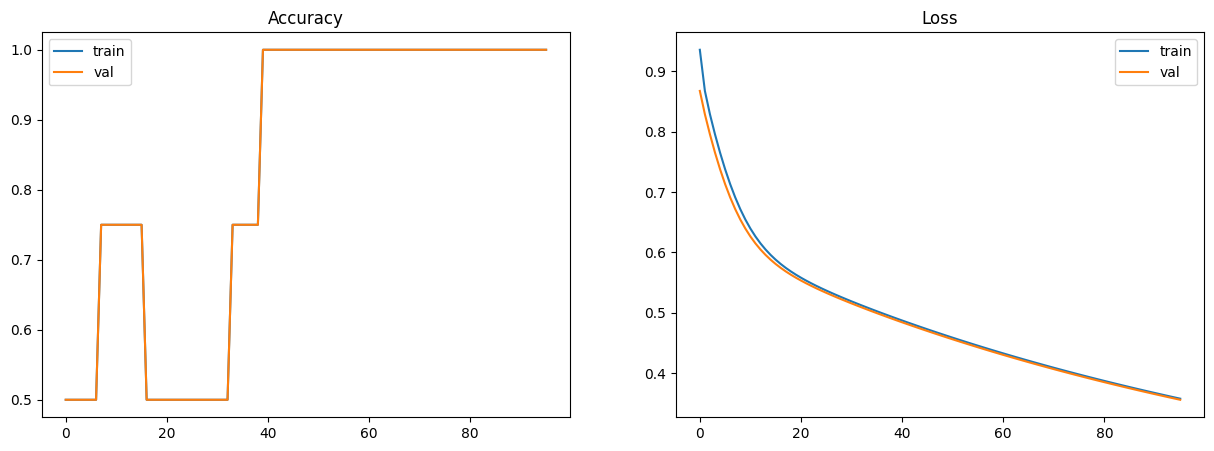

In [35]:
# Get preprocessed training and validation data

X_train = np.array([
    [1, 2, 1, 2],
    [2, 4, 2, 4],
    [2, 1, 2, 1],
    [4, 2, 4, 2],
])

y_train = np.array([0, 1, 0, 1])
X_val = X_train.copy()
y_val = y_train.copy()

print(X_train.shape)
print(X_val.shape)


# define neural net
model = NN()

# add some layers (linear and ReLU)
model.add_layer(Linear(4,2))
model.add_layer(ReLU())

model = train(model, X_train , y_train, minibatch_size=4, epoch=100,
           learning_rate=0.1, X_val=X_val, y_val=y_val)


Task 7. Make a net configuration for Mnist training

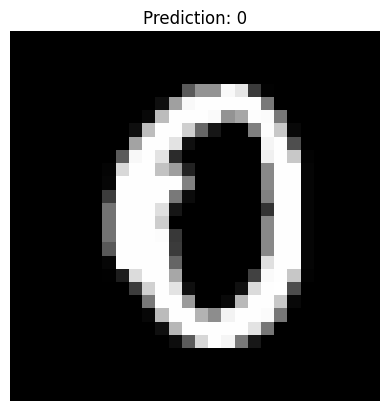

Epoch 1/10, Validation Loss: 0.3363
Epoch 2/10, Validation Loss: 0.2035
Epoch 3/10, Validation Loss: 0.2240
Epoch 4/10, Validation Loss: 0.1466
Epoch 5/10, Validation Loss: 0.1285
Epoch 6/10, Validation Loss: 0.2939
Epoch 7/10, Validation Loss: 0.1127
Epoch 8/10, Validation Loss: 0.1037
Epoch 9/10, Validation Loss: 0.1271
Epoch 10/10, Validation Loss: 0.1007


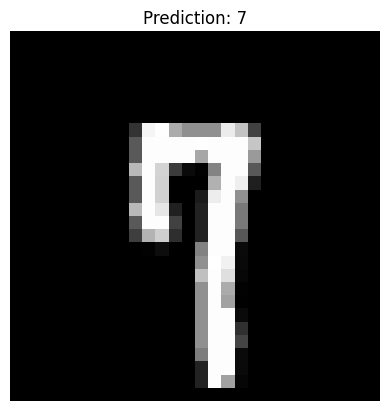

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Load MNIST data
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
y = y.astype(np.int32)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.25,
                                                  shuffle=True,
                                                  random_state=0)
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()

# Visualize a sample image
def vis(img, label):
    plt.imshow(img, cmap='gray')
    plt.title(f"Prediction: {label}")
    plt.axis('off')
    plt.show()

vis_idx = 0
vis(X_val[vis_idx].reshape(-1, 28), y_val[vis_idx])

# Define the neural network class
class NN:
    def __init__(self, input_size=784, hidden_size=128, output_size=10):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.W1 = np.random.randn(self.input_size, self.hidden_size) * 0.01
        self.b1 = np.zeros((1, self.hidden_size))
        self.W2 = np.random.randn(self.hidden_size, self.output_size) * 0.01
        self.b2 = np.zeros((1, self.output_size))

    def forward(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = np.maximum(0, self.Z1)  # ReLU
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.softmax(self.Z2)  # Softmax
        return self.A2

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def predict(self, X):
        A2 = self.forward(X)
        return np.argmax(A2, axis=1)

    def compute_loss(self, X, y):
        m = X.shape[0]
        A2 = self.forward(X)
        log_likelihood = -np.log(A2[range(m), y])
        loss = np.sum(log_likelihood) / m
        return loss

    def backward(self, X, y):
        m = X.shape[0]
        dZ2 = self.A2
        dZ2[range(m), y] -= 1
        dZ2 /= m
        dW2 = np.dot(self.A1.T, dZ2)
        db2 = np.sum(dZ2, axis=0, keepdims=True)
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * (self.Z1 > 0)
        dW1 = np.dot(X.T, dZ1)
        db1 = np.sum(dZ1, axis=0, keepdims=True)
        return dW1, db1, dW2, db2

    def update_parameters(self, dW1, db1, dW2, db2, learning_rate):
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2

# Train the model
def train(model, X_train, y_train, minibatch_size=128, epoch=10, learning_rate=0.001, X_val=None, y_val=None, draw_each_iters=1):
    for e in range(epoch):
        permutation = np.random.permutation(X_train.shape[0])
        X_train_shuffled = X_train[permutation]
        y_train_shuffled = y_train[permutation]
        for i in range(0, X_train.shape[0], minibatch_size):
            X_batch = X_train_shuffled[i:i+minibatch_size]
            y_batch = y_train_shuffled[i:i+minibatch_size]
            model.forward(X_batch)
            dW1, db1, dW2, db2 = model.backward(X_batch, y_batch)
            model.update_parameters(dW1, db1, dW2, db2, learning_rate)

        if X_val is not None and y_val is not None and e % draw_each_iters == 0:
            val_loss = model.compute_loss(X_val, y_val)
            print(f"Epoch {e+1}/{epoch}, Validation Loss: {val_loss:.4f}")

    return model

# Create and train the model
model = NN()
model = train(model, X_train, y_train, minibatch_size=128, epoch=10, learning_rate=0.001, X_val=X_val, y_val=y_val)

# Visualize prediction
vis_idx = 23
pred = model.predict(X_val[vis_idx:vis_idx+1])
vis(X_val[vis_idx].reshape(-1, 28), pred[0])


Extra* Task 8. Try to make you digit classification better by playing with neural net configuration (accuracy > 90%)

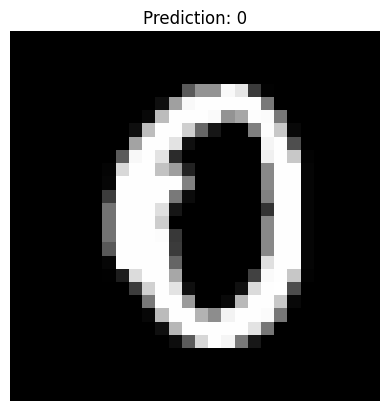

Epoch 1/10, Validation Loss: 0.1405
Epoch 2/10, Validation Loss: 0.1243
Epoch 3/10, Validation Loss: 0.1104
Epoch 4/10, Validation Loss: 0.1551
Epoch 5/10, Validation Loss: 0.1294
Epoch 6/10, Validation Loss: 0.1332
Epoch 7/10, Validation Loss: 0.1686
Epoch 8/10, Validation Loss: 0.2074
Epoch 9/10, Validation Loss: 0.1578
Epoch 10/10, Validation Loss: 0.1320


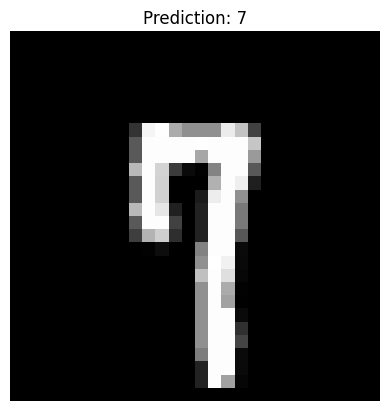

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Load MNIST data
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
y = y.astype(np.int32)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.25,
                                                  shuffle=True,
                                                  random_state=0)
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()

# Visualize a sample image
def vis(img, label):
    plt.imshow(img, cmap='gray')
    plt.title(f"Prediction: {label}")
    plt.axis('off')
    plt.show()

vis_idx = 0
vis(X_val[vis_idx].reshape(-1, 28), y_val[vis_idx])

# Define the neural network class with improvements
class NN:
    def __init__(self, input_size=784, hidden_size1=256, hidden_size2=128, output_size=10):
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size

        # Initialize weights and biases for 2 hidden layers
        self.W1 = np.random.randn(self.input_size, self.hidden_size1) * 0.01
        self.b1 = np.zeros((1, self.hidden_size1))
        self.W2 = np.random.randn(self.hidden_size1, self.hidden_size2) * 0.01
        self.b2 = np.zeros((1, self.hidden_size2))
        self.W3 = np.random.randn(self.hidden_size2, self.output_size) * 0.01
        self.b3 = np.zeros((1, self.output_size))

        # Dropout rate (for regularization)
        self.dropout_rate = 0.5

    def forward(self, X, training=True):
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = np.maximum(0, self.Z1)  # ReLU activation for the first hidden layer

        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = np.maximum(0, self.Z2)  # ReLU activation for the second hidden layer

        self.Z3 = np.dot(self.A2, self.W3) + self.b3
        self.A3 = self.softmax(self.Z3)  # Softmax for output

        # Apply dropout (if training)
        if training:
            self.dropout_mask = (np.random.rand(*self.A2.shape) > self.dropout_rate)
            self.A2 = self.A2 * self.dropout_mask  # Apply dropout during training
        return self.A3

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # For numerical stability
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def predict(self, X):
        A3 = self.forward(X, training=False)
        return np.argmax(A3, axis=1)

    def compute_loss(self, X, y):
        m = X.shape[0]
        A3 = self.forward(X, training=False)
        log_likelihood = -np.log(A3[range(m), y])
        loss = np.sum(log_likelihood) / m
        return loss

    def backward(self, X, y):
        m = X.shape[0]

        dZ3 = self.A3
        dZ3[range(m), y] -= 1
        dZ3 /= m

        # Gradients for W3 and b3
        dW3 = np.dot(self.A2.T, dZ3)
        db3 = np.sum(dZ3, axis=0, keepdims=True)

        # Backpropagation through the second hidden layer
        dA2 = np.dot(dZ3, self.W3.T)
        dZ2 = dA2 * (self.Z2 > 0)  # ReLU derivative
        dW2 = np.dot(self.A1.T, dZ2)
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        # Backpropagation through the first hidden layer
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * (self.Z1 > 0)  # ReLU derivative
        dW1 = np.dot(X.T, dZ1)
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        return dW1, db1, dW2, db2, dW3, db3

    def update_parameters(self, dW1, db1, dW2, db2, dW3, db3, learning_rate):
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W3 -= learning_rate * dW3
        self.b3 -= learning_rate * db3

# Change the training function to use Adam optimizer and better configuration
def train(model, X_train, y_train, minibatch_size=128, epoch=10, learning_rate=0.001, X_val=None, y_val=None, draw_each_iters=1):
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8

    m_W1, v_W1 = np.zeros_like(model.W1), np.zeros_like(model.W1)
    m_b1, v_b1 = np.zeros_like(model.b1), np.zeros_like(model.b1)
    m_W2, v_W2 = np.zeros_like(model.W2), np.zeros_like(model.W2)
    m_b2, v_b2 = np.zeros_like(model.b2), np.zeros_like(model.b2)
    m_W3, v_W3 = np.zeros_like(model.W3), np.zeros_like(model.W3)
    m_b3, v_b3 = np.zeros_like(model.b3), np.zeros_like(model.b3)

    t = 0  # Time step for Adam

    for e in range(epoch):
        permutation = np.random.permutation(X_train.shape[0])
        X_train_shuffled = X_train[permutation]
        y_train_shuffled = y_train[permutation]

        for i in range(0, X_train.shape[0], minibatch_size):
            X_batch = X_train_shuffled[i:i+minibatch_size]
            y_batch = y_train_shuffled[i:i+minibatch_size]

            # Forward pass
            model.forward(X_batch)

            # Backward pass
            dW1, db1, dW2, db2, dW3, db3 = model.backward(X_batch, y_batch)

            # Adam update
            t += 1
            m_W1 = beta1 * m_W1 + (1 - beta1) * dW1
            v_W1 = beta2 * v_W1 + (1 - beta2) * (dW1 ** 2)
            m_b1 = beta1 * m_b1 + (1 - beta1) * db1
            v_b1 = beta2 * v_b1 + (1 - beta2) * (db1 ** 2)

            m_W2 = beta1 * m_W2 + (1 - beta1) * dW2
            v_W2 = beta2 * v_W2 + (1 - beta2) * (dW2 ** 2)
            m_b2 = beta1 * m_b2 + (1 - beta1) * db2
            v_b2 = beta2 * v_b2 + (1 - beta2) * (db2 ** 2)

            m_W3 = beta1 * m_W3 + (1 - beta1) * dW3
            v_W3 = beta2 * v_W3 + (1 - beta2) * (dW3 ** 2)
            m_b3 = beta1 * m_b3 + (1 - beta1) * db3
            v_b3 = beta2 * v_b3 + (1 - beta2) * (db3 ** 2)

            # Bias correction
            m_W1_hat = m_W1 / (1 - beta1 ** t)
            v_W1_hat = v_W1 / (1 - beta2 ** t)
            m_b1_hat = m_b1 / (1 - beta1 ** t)
            v_b1_hat = v_b1 / (1 - beta2 ** t)

            m_W2_hat = m_W2 / (1 - beta1 ** t)
            v_W2_hat = v_W2 / (1 - beta2 ** t)
            m_b2_hat = m_b2 / (1 - beta1 ** t)
            v_b2_hat = v_b2 / (1 - beta2 ** t)

            m_W3_hat = m_W3 / (1 - beta1 ** t)
            v_W3_hat = v_W3 / (1 - beta2 ** t)
            m_b3_hat = m_b3 / (1 - beta1 ** t)
            v_b3_hat = v_b3 / (1 - beta2 ** t)

            # Update parameters
            model.W1 -= learning_rate * m_W1_hat / (np.sqrt(v_W1_hat) + epsilon)
            model.b1 -= learning_rate * m_b1_hat / (np.sqrt(v_b1_hat) + epsilon)
            model.W2 -= learning_rate * m_W2_hat / (np.sqrt(v_W2_hat) + epsilon)
            model.b2 -= learning_rate * m_b2_hat / (np.sqrt(v_b2_hat) + epsilon)
            model.W3 -= learning_rate * m_W3_hat / (np.sqrt(v_W3_hat) + epsilon)
            model.b3 -= learning_rate * m_b3_hat / (np.sqrt(v_b3_hat) + epsilon)

        # Validation and logging
        if X_val is not None and y_val is not None and e % draw_each_iters == 0:
            val_loss = model.compute_loss(X_val, y_val)
            print(f"Epoch {e+1}/{epoch}, Validation Loss: {val_loss:.4f}")

    return model

# Create and train the model
model = NN()
model = train(model, X_train, y_train, minibatch_size=128, epoch=10, learning_rate=0.001, X_val=X_val, y_val=y_val)

# Visualize prediction
vis_idx = 23
pred = model.predict(X_val[vis_idx:vis_idx+1])
vis(X_val[vis_idx].reshape(-1, 28), pred[0])
